# Clasificación según distribución de $PM_{2.5}/PM_{10}$

En este código se realiza la clasificación de los datos según la distribución de $PM_{2.5}/PM_{10}$, clasificación propuesta en el artículo de [Fan, H., Zhao, C., Yang, Y., & Yang, X. (2021)](https://doi.org/10.3389/fenvs.2021.692440). Para esto, se utilizarán los datos de las estaciones de monitoreo de Bogotá del año 2022. De estos se hallará el valor del pico, la kurtosis y la asimetría de la distribución de $PM_{2.5}/PM_{10}$ para cada estación. La clasificación se realizará según los siguientes criterios:  
![Clasificación de los contaminantes](../img/clasificacion_pm_ratio.jpg) 

In [1]:
# importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import timedelta
import bs4 as bs
import requests
import re

## 1. Importación de datos

Importación todos los datos de las estaciones de monitoreo de Bogotá

In [2]:
# array con los nombres código de las estaciones
estaciones = ["BOL","CBV","CDAR","COL","CSE","FTB",
              "GYR","JAZ","KEN","LFR","MAM","MOV1",
              "MOV2","PTE","SCR","SUB","TUN","USM","USQ"]

# definimos la función para importar los datos de las estaciones
def importar_datos_individuales(estaciones, año):
    # importamos los datos de las estaciones y cada DataFrame lo guardamos en un diccionario
    datos = {}
    for i in estaciones:
        # importamos un set de datos
        data = pd.read_excel(
            "../data/"+str(año)+"/" + str(i) + "_"+str(año)+".xlsx", skiprows=3, skipfooter=11, index_col=0
        )[["PM10", "PM2.5"]] # importamos las columnas de PM10 y PM2.5

        # eliminamos la fila de unidades
        data.drop(data.index[0], inplace=True)

        # cambiamos el indice a tipo fecha, cambiando el 24:00 por 00:00 del otro día
        data.index = pd.to_datetime(
            data.index.str.replace("24:00", "00:00"), format="%d-%m-%Y %H:%M"
        )
        new_index = []
        for j in range(len(data.index)):
            new_index.append(data.index[j])
            if data.index[j].hour == 0:  # si la hora es 00:00 le sumamos un día
                new_index[j] = data.index[j] + timedelta(days=1)
        data.index = new_index

        # cambiamos el tipo de datos a float
        data["PM10"] = pd.to_numeric(data["PM10"], errors="coerce")
        data["PM2.5"] = pd.to_numeric(data["PM2.5"], errors="coerce")

        # eliminamos los datos nulos
        data.dropna(inplace=True)

        # creamos la columna con la relacion PM2.5/PM10
        data["ratio"] = data["PM2.5"] / data["PM10"]

        # eliminamos todas las entradas en las que el ratio es mayor o igual a 1 y menor o igual a 0
        data = data[data["ratio"] < 1]
        data = data[data["ratio"] > 0]

        # guardamos el DataFrame con su nombre en el diccionario
        datos[i] = data

    # calculamos el procentaje de datos que tenemos en cada estacion: datos validos/8760 (8760 horas en un año)
    porcentaje_datos = {}
    for i in estaciones:
        porcentaje_datos[i] = len(datos[i]) / 8760

    # # descartamos las estaciones que tienen menos del 70% de datos validos
    # estaciones = [i for i in estaciones if porcentaje_datos[i] >= 0.7]
    # datos = {i: datos[i] for i in estaciones}

    return datos, porcentaje_datos

# importamos los datos de las estaciones para cada año
datos_2020, porcentaje_datos_2020 = importar_datos_individuales(estaciones, 2020)
datos_2021, porcentaje_datos_2021 = importar_datos_individuales(estaciones, 2021)
datos_2022, porcentaje_datos_2022 = importar_datos_individuales(estaciones, 2022)

Visualización de los porcentajes de datos respecto a los de un año

In [3]:
# imprimimos el porcentaje de datos validos de cada estacion
print("Porcentaje de datos validos en 2020 -> 2021 -> 2022:")
for i, estacion in enumerate(estaciones):
    print(f"{i+1}. {estacion}: {porcentaje_datos_2020[estacion]*100:.2f}% -> {porcentaje_datos_2021[estacion]*100:.2f}% -> {porcentaje_datos_2022[estacion]*100:.2f}%")

Porcentaje de datos validos en 2020 -> 2021 -> 2022:
1. BOL: 18.97% -> 95.09% -> 84.37%
2. CBV: 20.08% -> 93.64% -> 92.28%
3. CDAR: 75.68% -> 71.68% -> 81.91%
4. COL: 0.00% -> 67.11% -> 88.07%
5. CSE: 89.42% -> 79.62% -> 19.10%
6. FTB: 86.74% -> 81.91% -> 94.24%
7. GYR: 81.36% -> 83.64% -> 91.11%
8. JAZ: 22.60% -> 91.91% -> 93.38%
9. KEN: 92.81% -> 86.70% -> 83.42%
10. LFR: 76.07% -> 75.55% -> 84.32%
11. MAM: 72.68% -> 70.96% -> 75.02%
12. MOV1: 91.96% -> 81.48% -> 54.75%
13. MOV2: 0.00% -> 68.25% -> 92.98%
14. PTE: 81.64% -> 58.09% -> 40.10%
15. SCR: 80.31% -> 69.77% -> 79.54%
16. SUB: 85.11% -> 83.42% -> 74.37%
17. TUN: 91.56% -> 84.92% -> 88.13%
18. USM: 19.45% -> 91.07% -> 92.55%
19. USQ: 35.62% -> 46.18% -> 74.26%


Eliminación de los datos cuyo porcentaje es menor al 70%

In [3]:
# en cada grupo de datos por año, eliminamos las estaciones con menos del 70% de datos validos
estaciones_2020 = [i for i in estaciones if porcentaje_datos_2020[i] >= 0.7]
datos_2020 = {i: datos_2020[i] for i in estaciones_2020}
estaciones_2021 = [i for i in estaciones if porcentaje_datos_2021[i] >= 0.7]
datos_2021 = {i: datos_2021[i] for i in estaciones_2021}
estaciones_2022 = [i for i in estaciones if porcentaje_datos_2022[i] >= 0.7]
datos_2022 = {i: datos_2022[i] for i in estaciones_2022}

# imprimimos la cantidad de estaciones en cada año
print("\nCantidad de estaciones en 2020 -> 2021 -> 2022:")
print(f"{len(estaciones_2020)} -> {len(estaciones_2021)} -> {len(estaciones_2022)}")



Cantidad de estaciones en 2020 -> 2021 -> 2022:
12 -> 14 -> 16


Estaciones que cumplen con el porcentaje de datos en cada año

In [ ]:
print("Estaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2020):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2020[estacion]*100:.2f}%")

print("\nEstaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2021):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2021[estacion]*100:.2f}%")

print("\nEstaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2022):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2022[estacion]*100:.2f}%")

## 2. Clasificación de contaminantes por en cada estación

Definimos las funciones de graficación de los histogramas, de clasificación de los contaminantes y de mapeado sobre el mapa de Bogotá

In [67]:
# definimos las constantes

lim_inf = 0.4  # limites de clasificación y el numero de bins
lim_sup = 0.6
n_bins = "doane" # metodo de calculo de los bins

tipos = {      # tipos de contaminantes
    1.1: "Typical Dust type (Ia)",
    1.2: "Atypical Dust type (Ib)",
    2.1: "Typical Mixed type (IIa)",
    2.21: "Mixed-Anthropogenic type (IIb1)",
    2.22: "Mixed-Dust type (IIb2)",
    3.1: "Typical Anthropogenic type (IIIa)",
    3.2: "Atypical Anthropogenic type (IIIb)",
}

url = "https://ambientebogota.gov.co/estaciones-rmcab" # url de la pagina de la RMCAB


colores = {     # colores para cada tipo de contaminante en el mapa
    1.1: "saddlebrown",
    1.2: "chocolate",
    2.1: "black",
    2.21: "midnightblue",
    2.22: "mediumpurple",
    3.1: "#e40000",
    3.2: "#ff4c4c",
}

# definimos la función para graficar los histogramas
def graficar_histogramas(datos, estaciones, año):
    # graficamos el histograma de la relacion PM2.5/PM10 para cada estacion
    fig, ax = plt.subplots(4, np.ceil(len(estaciones)/4).astype("int"), figsize=(17, 12))
    ax = ax.ravel()  # convertimos el array de 4x4 a 1x16

    for i in range(len(estaciones)):
        ax[i].hist(
            datos[estaciones[i]]["ratio"],
            bins=n_bins,
            edgecolor="black",
            histtype="bar",
            color="darkorchid",
            align="mid",
            range=(0, 1),
        )
        ax[i].axvline(lim_inf, color="red", linestyle="dashed")
        ax[i].axvline(lim_sup, color="red", linestyle="dashed")
        ax[i].set_title(estaciones[i], fontsize=15, fontweight="bold")
        ax[i].grid(alpha=0.5)
        ax[i].set_axisbelow(True)  # para que la grilla quede detras de las barras
        ax[i].tick_params(
            axis="both", which="major", labelsize=11, length=4
        )  # tamaño de los numeros en los ejes

    # agregamos espacio entre los subplots
    fig.subplots_adjust(hspace=0.3, wspace=0.15, left=0.08)

    # agregamos un solo texto centrado en la parte inferior
    fig.text(0.5, 0.05, r"$PM_{2.5}/PM_{10}$ "+str(año), ha="center", fontsize=22)

    # agregamos un solo texto centrado verticalmente en la parte izquierda
    fig.text(0.02, 0.5, "Frecuencia", va="center", rotation="vertical", fontsize=25)

# definimos la función para clasificar los datos de cada estacion según la clasificación de propuesta por el paper
def clasificacion(parametros):
    # parametros = [peak, kurtosis, skewness]
    if parametros[0] <= lim_inf:
        if parametros[1] >= 0:
            return 1.1
        elif parametros[1] < 0:
            return 1.2
    elif parametros[0] > lim_inf and parametros[0] < lim_sup:
        if parametros[1] >= 0:
            return 2.1
        elif parametros[1] < 0:
            if parametros[2] >= 0:
                return 2.21
            elif parametros[2] < 0:
                return 2.22
    elif parametros[0] >= lim_sup:
        if parametros[1] >= 0:
            return 3.1
        elif parametros[1] < 0:
            return 3.2

# definimos la función para clasificar los datos para cada set de datos
def clasificacion_set(datos, estaciones):
    # calculamos los parametros necesarios para la clasificacion
    parametros = {}
    for i in estaciones:
        hist, bin_edges = np.histogram(datos[i]["ratio"], bins=n_bins, range=(0, 1))
        # peak = bin_edges[np.argmax(hist)]
        peak = np.mean(bin_edges[np.argmax(hist):np.argmax(hist)+2])
        kurtosis = datos[i]["ratio"].kurtosis()
        skewness = datos[i]["ratio"].skew()
        parametros[i] = [peak, kurtosis, skewness]

    # clasificamos las estaciones
    clasificaciones = {}
    for i in estaciones:
        clasificaciones[i] = clasificacion(parametros[i])

    # imprimimos las clasificaciones
    print("Clasificaciones:")
    for i in estaciones:
        print(f"{i}: {tipos[clasificaciones[i]]}")
    
    return clasificaciones

# definimos la función para mapear usando plotly
def mapear_plotly(estaciones, clasificaciones, año):
    # obtenemos la longitud y latitud de cada estacion desde el sitio web de la secretaria de ambiente de bogota
    soup = bs.BeautifulSoup(
        requests.get(url).text, "html.parser"
    )
    coordenadas = {}  # diccionario con las coordenadas de cada estacion [latitud, longitud]
    for i in estaciones:

        if i != "MOV1": # MOV1 no aparece en la pagina de la RMCAB
            coordenadas[i] = [
                soup.find("td", string=i).find_next_sibling().text.replace(" ", ""),
                soup.find("td", string=i).find_next_sibling().find_next_sibling().text.replace(" ", ""),
            ]
        elif i == "MOV1":
            coordenadas[i] = ["4°38'42.7\"N", "74°03'41.6\"W"]

    # convertimos las coordenadas a float
    def convertir_coordenada(coordenada):
        grados, minutos, segundos, direccion = re.split("[°'\"]", coordenada)
        decimal = float(grados) + float(minutos) / 60 + float(segundos) / 3600
        if direccion in ["S", "W"]:
            decimal *= -1
        return decimal

    for i in estaciones:
        coordenadas[i][0] = convertir_coordenada(coordenadas[i][0])
        coordenadas[i][1] = convertir_coordenada(coordenadas[i][1])

    #graficamos las estaciones en un mapa
    fig = go.Figure(go.Scattermapbox(
        mode="markers",
        lon=[coordenadas[i][1] for i in estaciones],
        lat=[coordenadas[i][0] for i in estaciones],
        marker={"size": 15, "color": [colores.get(clasificaciones[i]) for i in estaciones]},
        text=[f"{i}: {tipos[clasificaciones[i]]}" for i in estaciones],
        showlegend=False,
    ))

    # construimos la leyenda de colores para el mapa
    for i in tipos.keys():
        fig.add_trace(
            go.Scattermapbox(
                lon=[-70],
                lat=[4.7],
                mode="markers",
                marker={"size": 10, "color": colores.get(i)},
                # showlegend=True,
                name=tipos.get(i),
            )
        )

    fig.update_layout(
        title = {
            "font": {"size": 24},
            "text": "Clasificación de contaminantes en Bogotá "+str(año),
            "x": 0.08,
            # "xanchor": "center",
            "y": 0.15,
            # "yanchor": "bottom",

        },
        mapbox={
            "style": "stamen-terrain",
            'center': {'lon': -74.1, 'lat': 4.65}, # centro de bogota
            "zoom": 10.4,
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        width=900,
        height=800,
        showlegend=True,
        # legend_title_text="Clasificaciones",
        # legend_font_size=15,
        # legend_orientation="h",
        legend = {
            "title": {"font": {"size": 20}, "text": "Clasificaciones"},
            "font": {"size": 15},
            "orientation": "h",
            "x": 0.08,
        },
    )

    # guardamos la imagen
    fig.write_image(f"../data/results/map_{año}.png")

    # mostramos la imagen
    fig.show()


### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2020

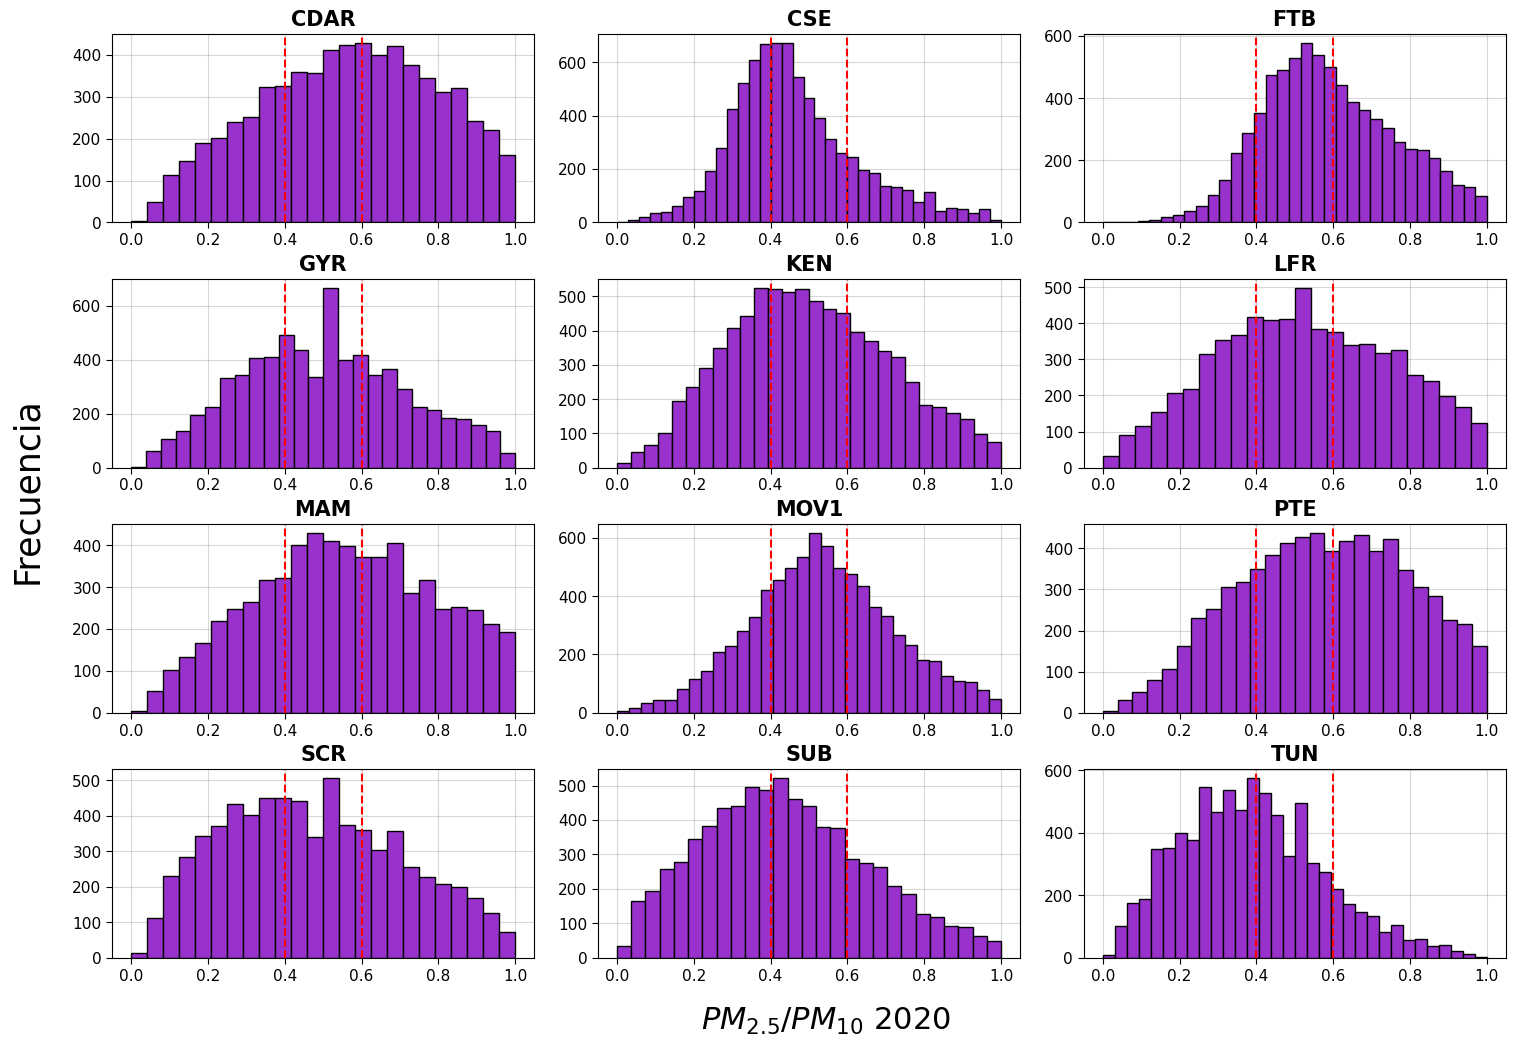

In [68]:
# graficamos los histogramas de los datos de 2020
graficar_histogramas(datos_2020, estaciones_2020, 2020)

In [59]:
# clasificamos los datos de 2020
clasificacion_2020 = clasificacion_set(datos_2020, estaciones_2020)

Clasificaciones:
CDAR: Atypical Anthropogenic type (IIIb)
CSE: Typical Mixed type (IIa)
FTB: Mixed-Anthropogenic type (IIb1)
GYR: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Mixed-Anthropogenic type (IIb1)
MAM: Mixed-Dust type (IIb2)
MOV1: Mixed-Anthropogenic type (IIb1)
PTE: Mixed-Dust type (IIb2)
SCR: Mixed-Anthropogenic type (IIb1)
SUB: Mixed-Anthropogenic type (IIb1)
TUN: Atypical Dust type (Ib)


In [60]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_2020, clasificacion_2020, 2020)

### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2021

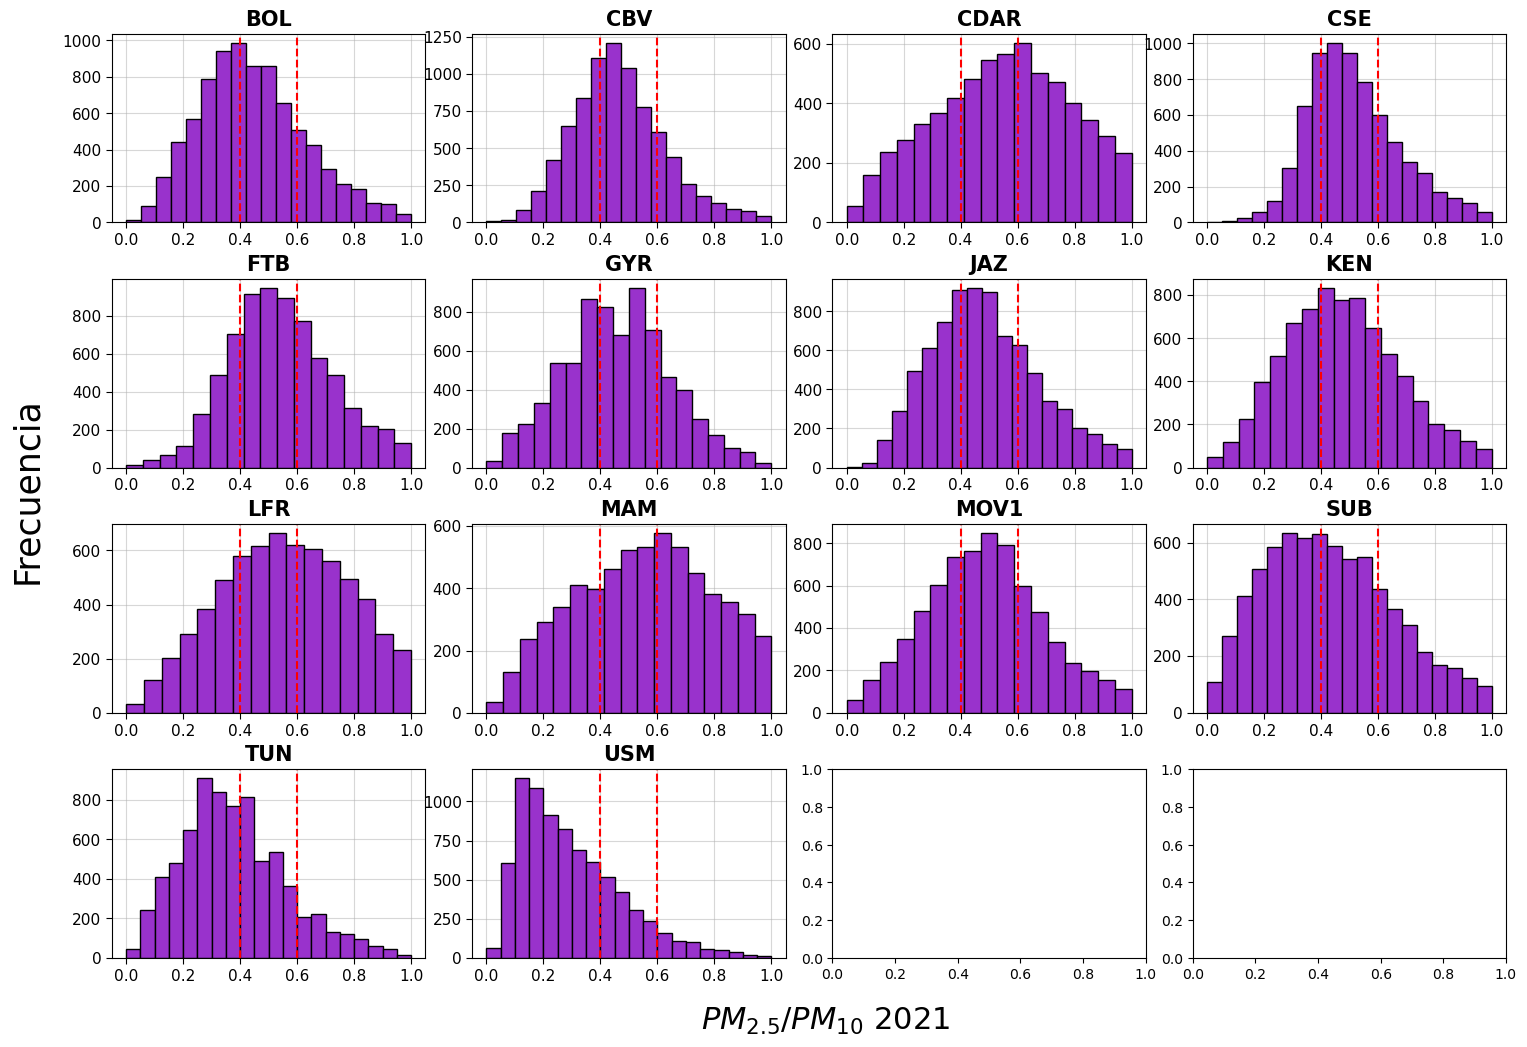

In [64]:
# graficamos los histogramas de los datos de 2021
graficar_histogramas(datos_2021, estaciones_2021, 2021)

In [65]:
# clasificamos los datos de 2021
clasificacion_2021 = clasificacion_set(datos_2021, estaciones_2021)

Clasificaciones:
BOL: Atypical Dust type (Ib)
CBV: Typical Mixed type (IIa)
CDAR: Atypical Anthropogenic type (IIIb)
CSE: Typical Mixed type (IIa)
FTB: Mixed-Anthropogenic type (IIb1)
GYR: Mixed-Anthropogenic type (IIb1)
JAZ: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Mixed-Dust type (IIb2)
MAM: Atypical Anthropogenic type (IIIb)
MOV1: Mixed-Anthropogenic type (IIb1)
SUB: Atypical Dust type (Ib)
TUN: Typical Dust type (Ia)
USM: Typical Dust type (Ia)


In [66]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_2021, clasificacion_2021, 2021)

### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2022

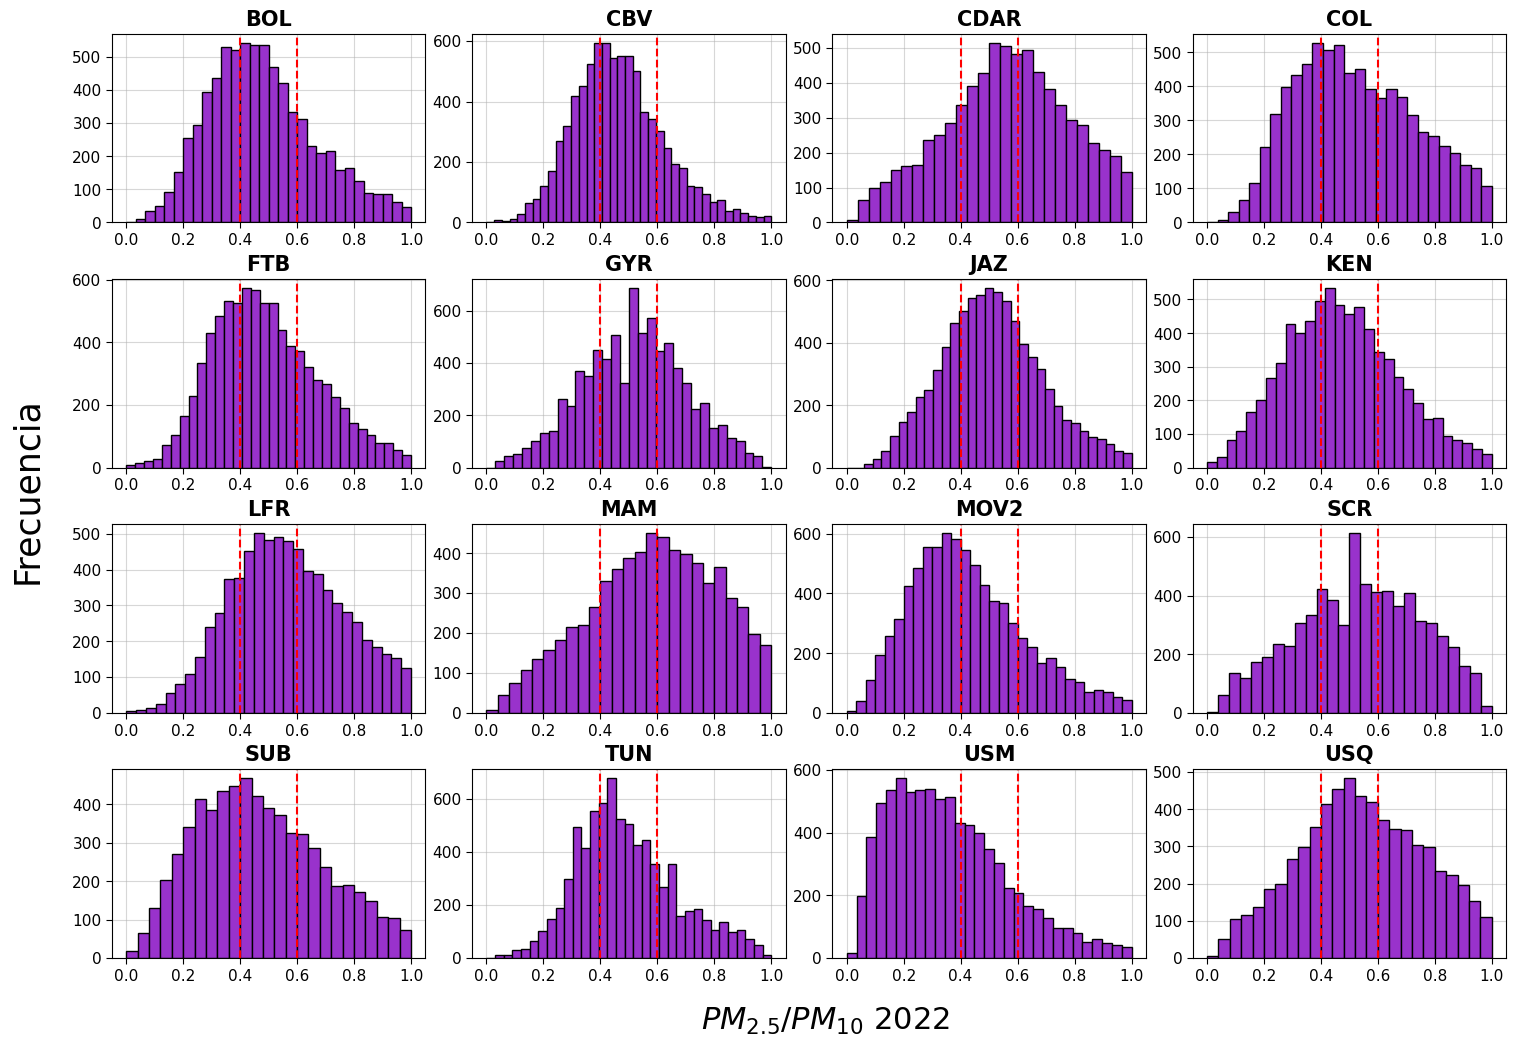

In [69]:
# graficamos los histogramas de los datos de 2022
graficar_histogramas(datos_2022, estaciones_2022, 2022)

In [70]:
# clasificamos los datos de 2022
clasificacion_2022 = clasificacion_set(datos_2022, estaciones_2022)

Clasificaciones:
BOL: Mixed-Anthropogenic type (IIb1)
CBV: Typical Dust type (Ia)
CDAR: Mixed-Dust type (IIb2)
COL: Atypical Dust type (Ib)
FTB: Mixed-Anthropogenic type (IIb1)
GYR: Mixed-Dust type (IIb2)
JAZ: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Mixed-Anthropogenic type (IIb1)
MAM: Mixed-Dust type (IIb2)
MOV2: Atypical Dust type (Ib)
SCR: Mixed-Dust type (IIb2)
SUB: Mixed-Anthropogenic type (IIb1)
TUN: Mixed-Anthropogenic type (IIb1)
USM: Typical Dust type (Ia)
USQ: Mixed-Dust type (IIb2)


In [71]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_2022, clasificacion_2022, 2022)

In [7]:
for i in colores.keys():
    print(f"{tipos[i]}: {colores[i]}")

Typical Dust type (Ia): darkblue
Atypical Dust type (Ib): blue
Typical Mixed type (IIa): darkgreen
Mixed-Anthropogenic type (IIb1): green
Mixed-Dust type (IIb2): greenyellow
Typical Anthropogenic type (IIIa): darkred
Atypical Anthropogenic type (IIIb): red


## 3. Correlación entre PM2.5, PM10 y PM2.5/PM10

Obtenemos los datos por año del promedio diario de todas las estaciones

In [4]:
# definimos la función que obtiene el promedio de los datos de todas las estaciones dada una frecuencia
def promedio_estaciones(datos, estaciones, freq):

    # creamos un dataframe para cada variable
    pm25 = pd.DataFrame()
    pm10 = pd.DataFrame()
    ratio = pd.DataFrame()

    # obtenemos los datos de cada estacion y los promediamos por frecuencia
    for i in estaciones:
        pm25[i] = datos[i]["PM2.5"].resample(freq).mean()
        pm10[i] = datos[i]["PM10"].resample(freq).mean()
        ratio[i] = datos[i]["ratio"].resample(freq).mean()

    # promediamos los datos de todas las estaciones
    pm25_mean = pm25.mean(axis=1)
    pm10_mean = pm10.mean(axis=1)
    ratio_mean = ratio.mean(axis=1)

    # calculamos la desviación estándar de los datos de todas las estaciones
    pm25_std = pm25.std(axis=1)
    pm10_std = pm10.std(axis=1)
    ratio_std = ratio.std(axis=1)

    # creamos un dataframe con los datos promediados
    datos_promedio = pd.DataFrame({"PM2.5": pm25_mean, "PM10": pm10_mean, "ratio": ratio_mean, "PM2.5_std": pm25_std, "PM10_std": pm10_std, "ratio_std": ratio_std})
    

    return datos_promedio

# obtenemos los datos promediados por hora de cada año
datos_2020_promedio = promedio_estaciones(datos_2020, estaciones_2020, "D")
datos_2021_promedio = promedio_estaciones(datos_2021, estaciones_2021, "D")
datos_2022_promedio = promedio_estaciones(datos_2022, estaciones_2022, "D")

Realizamos una regresión lineal entre PM2.5 y PM10, entre PM2.5 y PM2.5/PM10 y entre PM10 y PM2.5/PM10

In [23]:
# hacemos un array para cada año con las regresiones (polyfit) entre PM2.5 y PM10,
#PM2.5 y ratio, y PM10 y ratio respectivamente
regresiones_2020 = np.array([np.polyfit(datos_2020_promedio["PM2.5"], datos_2020_promedio["PM10"], 1),
                             np.polyfit(datos_2020_promedio["PM2.5"], datos_2020_promedio["ratio"], 1),
                             np.polyfit(datos_2020_promedio["PM10"], datos_2020_promedio["ratio"], 1)])

regresiones_2021 = np.array([np.polyfit(datos_2021_promedio["PM2.5"], datos_2021_promedio["PM10"], 1),
                             np.polyfit(datos_2021_promedio["PM2.5"], datos_2021_promedio["ratio"], 1),
                             np.polyfit(datos_2021_promedio["PM10"], datos_2021_promedio["ratio"], 1)])

regresiones_2022 = np.array([np.polyfit(datos_2022_promedio["PM2.5"], datos_2022_promedio["PM10"], 1),
                             np.polyfit(datos_2022_promedio["PM2.5"], datos_2022_promedio["ratio"], 1),
                             np.polyfit(datos_2022_promedio["PM10"], datos_2022_promedio["ratio"], 1)])

Graficamos los datos con sus respectivas regresiones lineales y sus coeficientes de correlación

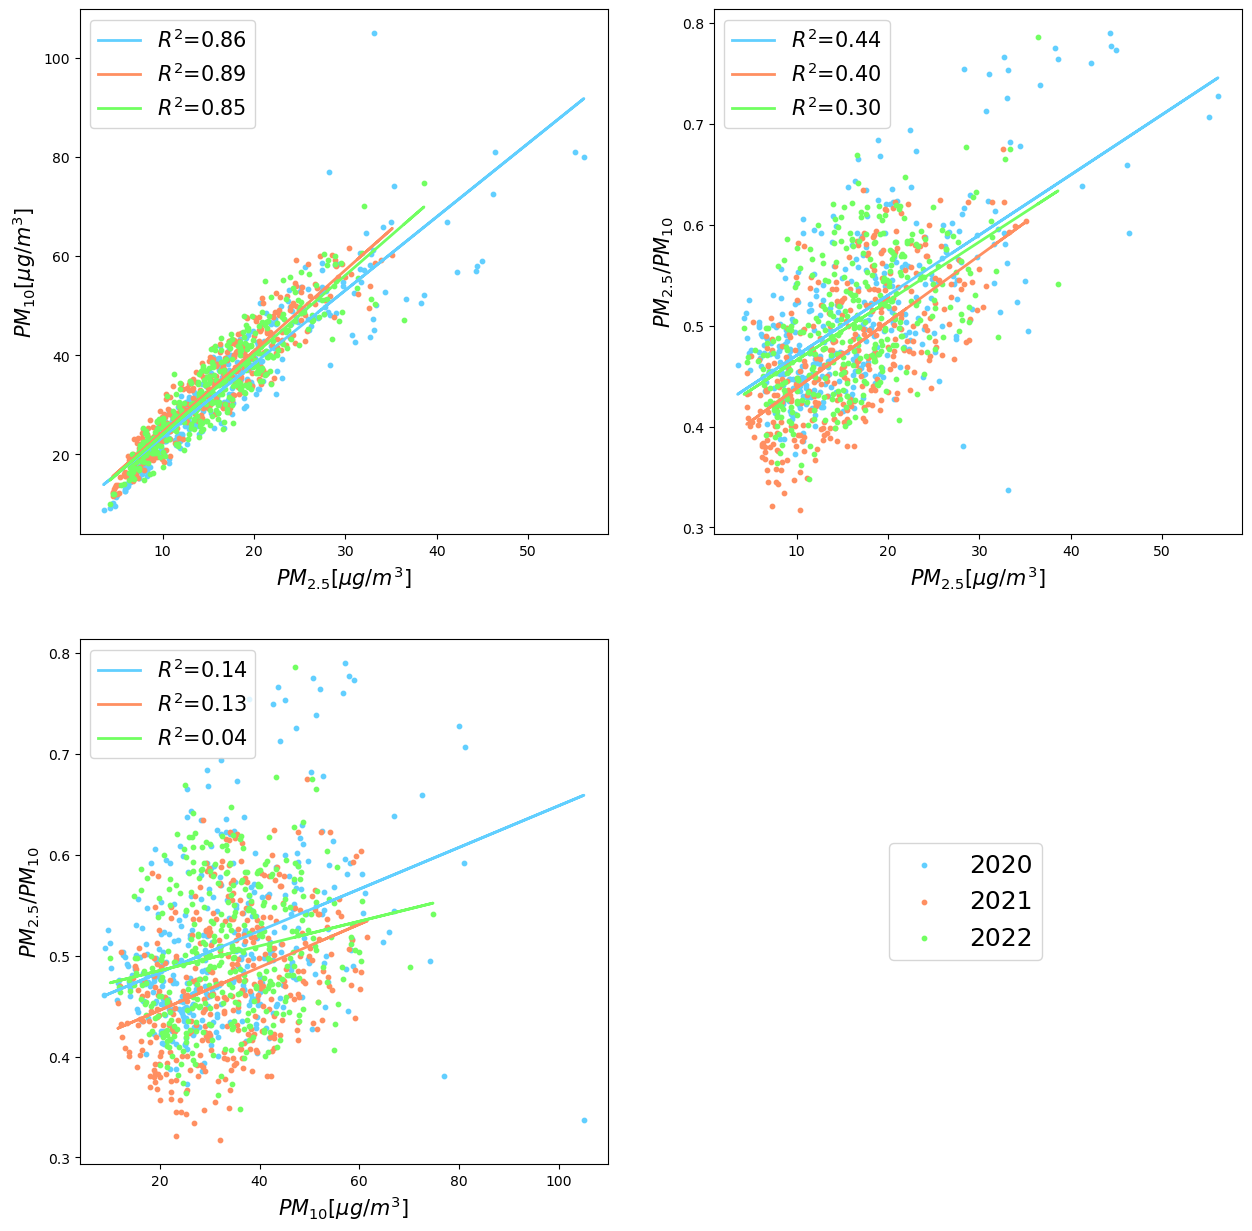

In [24]:
# creamos la figura
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# graficamos las relaciones entre PM2.5 y PM10
lineone = ax[0, 0].scatter(datos_2020_promedio["PM2.5"],
                 datos_2020_promedio["PM10"],
                 s=10,
                 color="#61cfff",
                 )
ax[0, 0].plot(datos_2020_promedio["PM2.5"],
              regresiones_2020[0, 0]*datos_2020_promedio["PM2.5"]+regresiones_2020[0, 1],
              color="#61cfff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2020_promedio["PM2.5"], datos_2020_promedio["PM10"])[0,1]**2, 2))
              )

linetwo = ax[0, 0].scatter(datos_2021_promedio["PM2.5"],
                 datos_2021_promedio["PM10"],
                 s=10,
                 color="#ff8f61",
                 )
ax[0, 0].plot(datos_2021_promedio["PM2.5"],
              regresiones_2021[0, 0]*datos_2021_promedio["PM2.5"]+regresiones_2021[0, 1],
              color="#ff8f61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2021_promedio["PM2.5"], datos_2021_promedio["PM10"])[0,1]**2, 2))
              )

linethree = ax[0, 0].scatter(datos_2022_promedio["PM2.5"],
                 datos_2022_promedio["PM10"],
                 s=10,
                 color="#71ff61",
                 )
ax[0, 0].plot(datos_2022_promedio["PM2.5"],
              regresiones_2022[0, 0]*datos_2022_promedio["PM2.5"]+regresiones_2022[0, 1],
              color="#71ff61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2022_promedio["PM2.5"], datos_2022_promedio["PM10"])[0,1]**2, 2))
              )

# graficamos las relaciones entre PM2.5 y ratio
ax[0, 1].scatter(datos_2020_promedio["PM2.5"],
                 datos_2020_promedio["ratio"],
                 s=10,
                 color="#61cfff",
                 )
ax[0, 1].plot(datos_2020_promedio["PM2.5"],
              regresiones_2020[1, 0]*datos_2020_promedio["PM2.5"]+regresiones_2020[1, 1],
              color="#61cfff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2020_promedio["PM2.5"], datos_2020_promedio["ratio"])[0,1]**2, 2))
              )

ax[0, 1].scatter(datos_2021_promedio["PM2.5"],
                 datos_2021_promedio["ratio"],
                 s=10,
                 color="#ff8f61",
                 )
ax[0, 1].plot(datos_2021_promedio["PM2.5"],
              regresiones_2021[1, 0]*datos_2021_promedio["PM2.5"]+regresiones_2021[1, 1],
              color="#ff8f61",
              linewidth=2,
            #   label= "$R^2$="+str(round(np.corrcoef(datos_2021_promedio["PM2.5"], datos_2021_promedio["ratio"])[0,1]**2, 2))
              label = "$R^2$={:.2f}".format(round(np.corrcoef(datos_2021_promedio["PM2.5"], datos_2021_promedio["ratio"])[0,1]**2, 2))
              )

ax[0, 1].scatter(datos_2022_promedio["PM2.5"],
                 datos_2022_promedio["ratio"],
                 s=10,
                 color="#71ff61",
                 )
ax[0, 1].plot(datos_2022_promedio["PM2.5"],
              regresiones_2022[1, 0]*datos_2022_promedio["PM2.5"]+regresiones_2022[1, 1],
              color="#71ff61",
              linewidth=2,
            #   label= "$R^2$="+str(round(np.corrcoef(datos_2022_promedio["PM2.5"], datos_2022_promedio["ratio"])[0,1]**2, 2))
              label = "$R^2$={:.2f}".format(round(np.corrcoef(datos_2022_promedio["PM2.5"], datos_2022_promedio["ratio"])[0,1]**2, 2))
              )

# graficamos las relaciones entre PM10 y ratio
ax[1, 0].scatter(datos_2020_promedio["PM10"],
                 datos_2020_promedio["ratio"],
                 s=10,
                 color="#61cfff",
                 )
ax[1, 0].plot(datos_2020_promedio["PM10"],
              regresiones_2020[2, 0]*datos_2020_promedio["PM10"]+regresiones_2020[2, 1],
              color="#61cfff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2020_promedio["PM10"], datos_2020_promedio["ratio"])[0,1]**2, 2))
              )

ax[1, 0].scatter(datos_2021_promedio["PM10"],
                 datos_2021_promedio["ratio"],
                 s=10,
                 color="#ff8f61",
                 )
ax[1, 0].plot(datos_2021_promedio["PM10"],
              regresiones_2021[2, 0]*datos_2021_promedio["PM10"]+regresiones_2021[2, 1],
              color="#ff8f61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2021_promedio["PM10"], datos_2021_promedio["ratio"])[0,1]**2, 2))
              )

ax[1, 0].scatter(datos_2022_promedio["PM10"],
                 datos_2022_promedio["ratio"],
                 s=10,
                 color="#71ff61",
                 )
ax[1, 0].plot(datos_2022_promedio["PM10"],
              regresiones_2022[2, 0]*datos_2022_promedio["PM10"]+regresiones_2022[2, 1],
              color="#71ff61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2022_promedio["PM10"], datos_2022_promedio["ratio"])[0,1]**2, 2))
              )

# añadimos los labels
ax[0, 0].set_xlabel(r"$PM_{2.5} [\mu g / m^3]$", fontsize=15)
ax[0, 0].set_ylabel(r"$PM_{10} [\mu g / m^3]$", fontsize=15)
ax[0, 1].set_xlabel(r"$PM_{2.5} [\mu g / m^3]$", fontsize=15)
ax[0, 1].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)
ax[1, 0].set_xlabel(r"$PM_{10} [\mu g / m^3]$", fontsize=15)
ax[1, 0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)

# eliminamos los ejes del 4to cuadrante
ax[1,1].axis("off")

# añadimos las leyendas
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[1,0].legend(fontsize=15)

fig.legend([lineone, linetwo, linethree], ["2020", "2021", "2022"], loc=(0.71,0.22), fontsize=18)

# guardamos la imagen
plt.savefig("../data/results/corelaciones.png", dpi=300, bbox_inches="tight")


## 4. Variacion temporal del material particulado y el cociente PM2.5/PM10

Generamos un DataFrame con los datos mensuales promediados de cada estación de los tres años

In [77]:
# hacemos un DataFrame para PM2.5 y PM10 de todas las estaciones de todos los años
pm25 = pd.DataFrame()
pm10 = pd.DataFrame()

# hacemos un loop para cada año ingresando todos los datos de cada estación
for i,j in [(datos_2020, estaciones_2020), (datos_2021, estaciones_2021), (datos_2022, estaciones_2022)]:
    for k in j:
        # concatenamos los datos de cada estación
        pm25 = pd.concat([pm25, i[k]["PM2.5"].resample("M").mean().reset_index(drop=True)[0:12]] , axis=1)
        pm10 = pd.concat([pm10, i[k]["PM10"].resample("M").mean().reset_index(drop=True)[0:12]] , axis=1)

# hacemos un DataFrame con los datos mensuales de PM2.5 y PM10 de todo el conjunto y sus desviaciones estándar
datos_mensual = pd.DataFrame({"PM2.5": pm25.mean(axis=1), "PM10": pm10.mean(axis=1), "PM2.5_std": pm25.std(axis=1), "PM10_std": pm10.std(axis=1)})

Graficamos el comportamiento mensual de los datos con barras para PM2.5 y PM10 lado a lado, y puntos-linea para el ratio (con escala a la derecha)

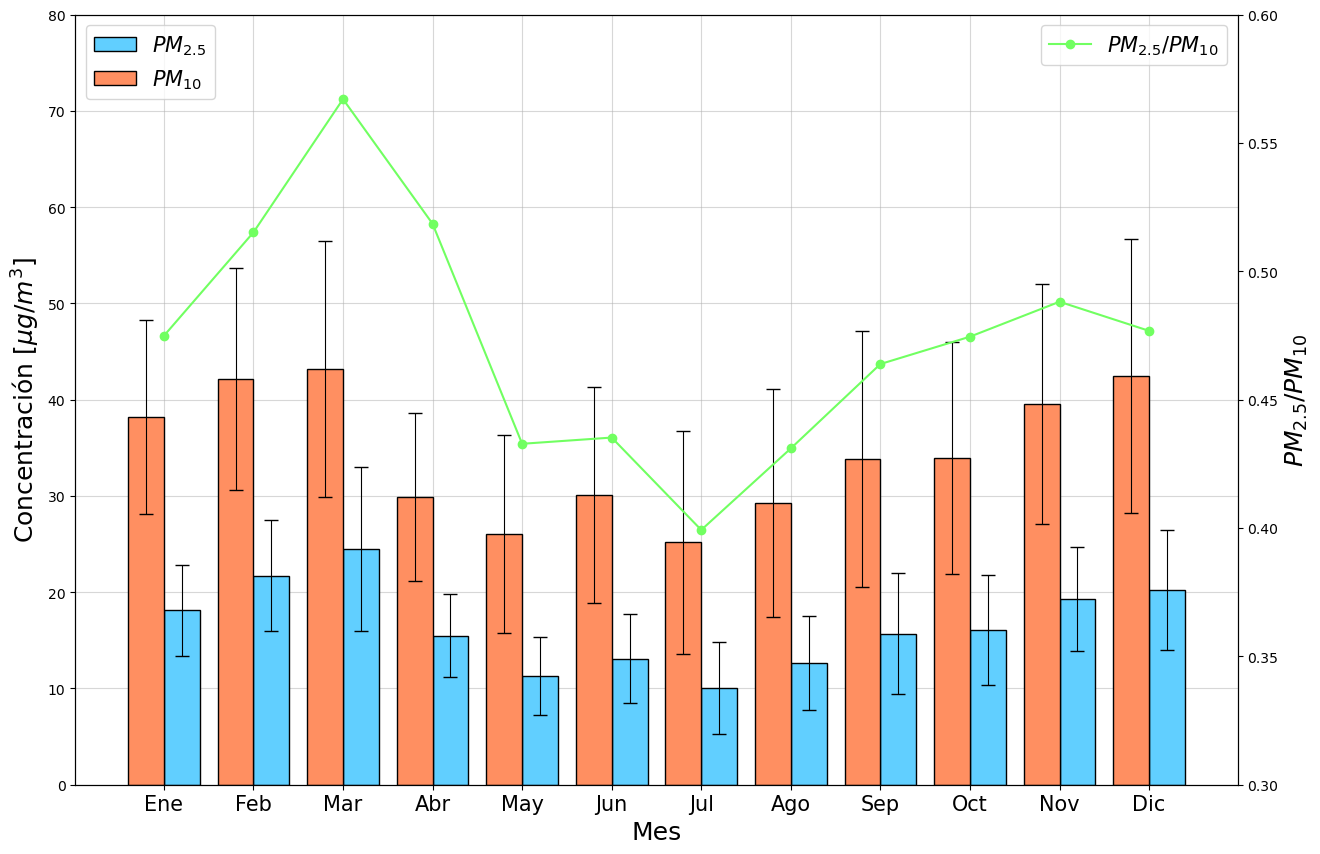

In [76]:
# creamos la figura
plt.figure(figsize=(15, 10))

# graficamos los datos PM2.5 y PM10 con su desviación estándar
plt.bar((datos_mensual.index+1)+0.2, datos_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
plt.bar((datos_mensual.index+1)-0.2, datos_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
plt.errorbar((datos_mensual.index+1+0.2), datos_mensual["PM2.5"], yerr=datos_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
plt.errorbar((datos_mensual.index+1-0.2), datos_mensual["PM10"], yerr=datos_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
plt.legend(fontsize=15, loc="upper left")
plt.xlabel("Mes", fontsize=18)
plt.ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
plt.ylim(0, 80)
plt.xticks(np.arange(1, 13), ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
plt.grid(alpha=0.5)
plt.gca().set_axisbelow(True)

# graficamos el ratio
plt.twinx() # creamos un segundo eje y
plt.plot(datos_mensual.index+1, datos_mensual["PM2.5"]/datos_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
plt.ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
plt.ylim(0.3, 0.6)
plt.legend(fontsize=15)

# guardamos la imagen
plt.savefig("../data/results/comportamiento_mensual.png", dpi=300, bbox_inches="tight")

# mostramos la imagen
plt.show()

Verificamos este comportamiento para cada año para ver si varía

C:\Users\nicom\AppData\Local\Temp\ipykernel_14252\71308388.py:97: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


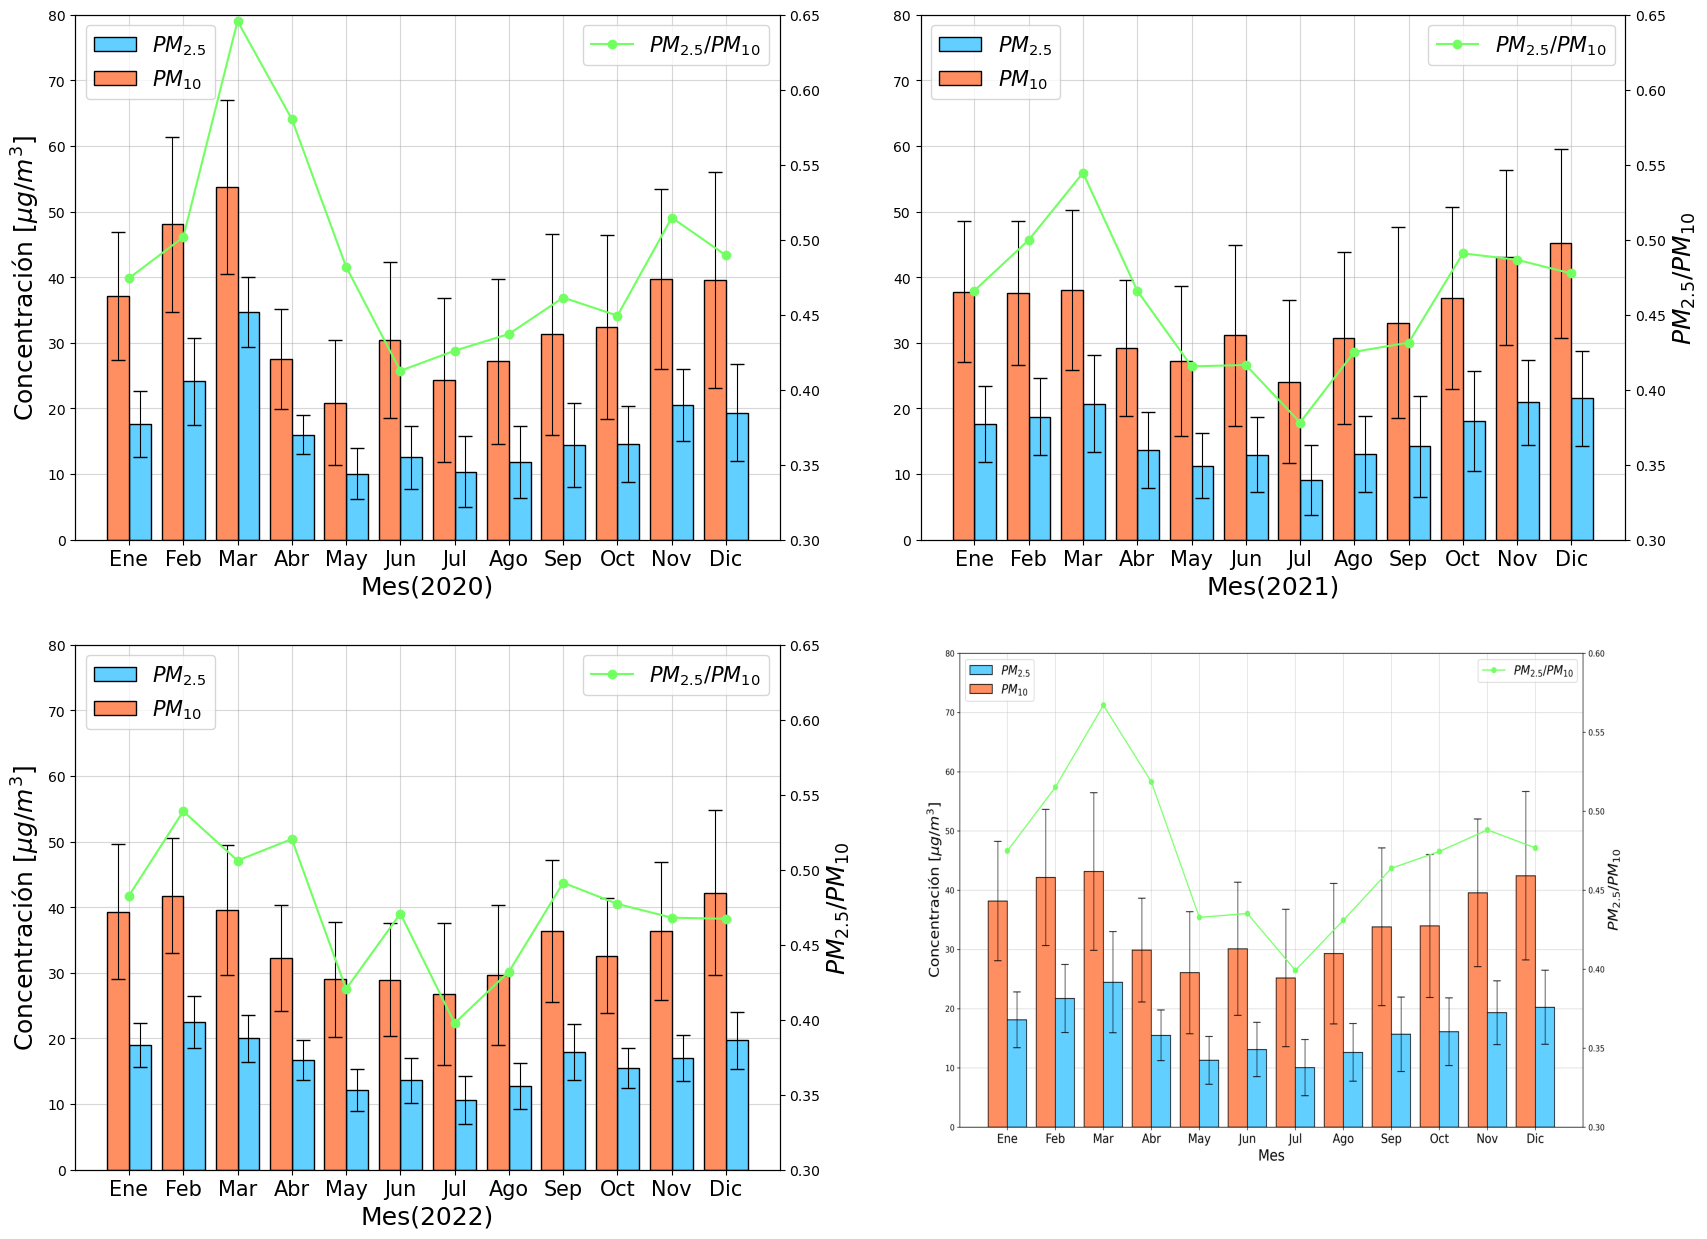

In [93]:
# creamos los dataframes de cada año de forma mensual
datos_2020_mensual = promedio_estaciones(datos_2020, estaciones_2020, "M")["2020-01-01":"2020-12-31"].reset_index(drop=True)
datos_2021_mensual = promedio_estaciones(datos_2021, estaciones_2021, "M")["2021-01-01":"2021-12-31"].reset_index(drop=True)
datos_2022_mensual = promedio_estaciones(datos_2022, estaciones_2022, "M")["2022-01-01":"2022-12-31"].reset_index(drop=True)

# realizamos la grafica de barras hecha en el punto anterior para cada año
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

#-----2020-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[0, 0].bar((datos_2020_mensual.index+1)+0.2, datos_2020_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[0, 0].bar((datos_2020_mensual.index+1)-0.2, datos_2020_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[0, 0].errorbar((datos_2020_mensual.index+1+0.2), datos_2020_mensual["PM2.5"], yerr=datos_2020_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[0, 0].errorbar((datos_2020_mensual.index+1-0.2), datos_2020_mensual["PM10"], yerr=datos_2020_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[0, 0].legend(fontsize=15, loc="upper left")
ax[0, 0].set_xlabel("Mes(2020)", fontsize=18)
ax[0, 0].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[0, 0].set_ylim(0, 80)
ax[0, 0].set_xticks(np.arange(1, 13))
ax[0, 0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].set_axisbelow(True)

# graficamos el ratio
a = ax[0, 0].twinx() # creamos un segundo eje y
a.plot(datos_2020_mensual.index+1, datos_2020_mensual["PM2.5"]/datos_2020_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
# ax[0, 0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
a.set_ylim(0.3, 0.65)
a.legend(fontsize=15)

#-----2021-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[0, 1].bar((datos_2021_mensual.index+1)+0.2, datos_2021_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[0, 1].bar((datos_2021_mensual.index+1)-0.2, datos_2021_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[0, 1].errorbar((datos_2021_mensual.index+1+0.2), datos_2021_mensual["PM2.5"], yerr=datos_2021_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[0, 1].errorbar((datos_2021_mensual.index+1-0.2), datos_2021_mensual["PM10"], yerr=datos_2021_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[0, 1].legend(fontsize=15, loc="upper left")
ax[0, 1].set_xlabel("Mes(2021)", fontsize=18)
# ax[0, 1].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[0, 1].set_ylim(0, 80)
ax[0, 1].set_xticks(np.arange(1, 13))
ax[0, 1].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_axisbelow(True)

# graficamos el ratio
b= ax[0, 1].twinx() # creamos un segundo eje y
b.plot(datos_2021_mensual.index+1, datos_2021_mensual["PM2.5"]/datos_2021_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
b.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
b.set_ylim(0.3, 0.65)
b.legend(fontsize=15)

#-----2022-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[1, 0].bar((datos_2022_mensual.index+1)+0.2, datos_2022_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[1, 0].bar((datos_2022_mensual.index+1)-0.2, datos_2022_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[1, 0].errorbar((datos_2022_mensual.index+1+0.2), datos_2022_mensual["PM2.5"], yerr=datos_2022_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[1, 0].errorbar((datos_2022_mensual.index+1-0.2), datos_2022_mensual["PM10"], yerr=datos_2022_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[1, 0].legend(fontsize=15, loc="upper left")
ax[1, 0].set_xlabel("Mes(2022)", fontsize=18)
ax[1, 0].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[1, 0].set_ylim(0, 80)
ax[1, 0].set_xticks(np.arange(1, 13))
ax[1, 0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_axisbelow(True)

# graficamos el ratio
c= ax[1, 0].twinx() # creamos un segundo eje y
c.plot(datos_2022_mensual.index+1, datos_2022_mensual["PM2.5"]/datos_2022_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
c.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
c.set_ylim(0.3, 0.65)
c.legend(fontsize=15)

# quitamos los ejes que no usamos
ax[1, 1].axis("off")

__ = plt.imread("../data/results/comportamiento_mensual.png")
ax[1, 1].imshow(__, aspect="auto")

# guardamos la figura
fig.savefig("../data/results/comportamiento_mensual_anual.png", dpi=300, bbox_inches="tight")

# mostramos el gráfico
fig.show()




### Recycle Bin

In [ ]:
# # importamos los datos de las estaciones y cada DataFrame lo guardamos en un diccionario
# datos = {}
# for i in estaciones:
#     # importamos un set de datos
#     data = pd.read_excel(
#         "../data/2022/" + str(i) + "_2022.xlsx", skiprows=3, skipfooter=11, index_col=0
#     )[["PM10", "PM2.5"]]

#     # eliminamos la fila de unidades
#     data.drop(data.index[0], inplace=True)

#     # cambiamos el indice a tipo fecha, cambiando el 24:00 por 00:00 del otro día
#     data.index = pd.to_datetime(
#         data.index.str.replace("24:00", "00:00"), format="%d-%m-%Y %H:%M"
#     )
#     new_index = []
#     for j in range(len(data.index)):
#         new_index.append(data.index[j])
#         if data.index[j].hour == 0:  # si la hora es 00:00 le sumamos un día
#             new_index[j] = data.index[j] + timedelta(days=1)
#     data.index = new_index

#     # cambiamos el tipo de datos a float
#     data["PM10"] = pd.to_numeric(data["PM10"], errors="coerce")
#     data["PM2.5"] = pd.to_numeric(data["PM2.5"], errors="coerce")

#     # eliminamos los datos nulos
#     data.dropna(inplace=True)

#     # creamos la columna con la relacion PM2.5/PM10
#     data["ratio"] = data["PM2.5"] / data["PM10"]

#     # guardamos el DataFrame con su nombre en el diccionario
#     datos[i] = data

#     # eliminamos todas las entradas en las que el ratio es mayor o igual a 1 y menor o igual a 0
#     datos[i] = datos[i][datos[i]["ratio"] < 1]
#     datos[i] = datos[i][datos[i]["ratio"] > 0]

In [ ]:
# #graficamos un histograma de los datos
# plt.figure(figsize=(10,5))
# plt.hist(data["ratio"], bins=25, edgecolor="black", histtype="bar", color="darkorchid", align= "mid")
# plt.axvline(0.4, color="red", linestyle="dashed")
# plt.axvline(0.6, color="red", linestyle="dashed")
# plt.xlabel("PM2.5/PM10")
# plt.ylabel("Frecuencia")
# plt.title("Histograma de la relación PM2.5/PM10")
# plt.grid(alpha=0.5)
# plt.gca().set_axisbelow(True)
# plt.show()

In [76]:
# obtenemos la longitud y latitud de cada estacion desde el sitio web de la secretaria de ambiente de bogota
soup = bs.BeautifulSoup(
    requests.get(url).text, "html.parser"
)
coordenadas = {}  # diccionario con las coordenadas de cada estacion [latitud, longitud]
for i in estaciones_2020:

    if i != "MOV1": # MOV1 no aparece en la pagina de la RMCAB
        coordenadas[i] = [
            soup.find("td", string=i).find_next_sibling().text.replace(" ", ""),
            soup.find("td", string=i).find_next_sibling().find_next_sibling().text.replace(" ", ""),
        ]
    elif i == "MOV1":
        coordenadas[i] = ["4°38'42.7\"N", "74°03'41.6\"W"]

# convertimos las coordenadas a float
def convertir_coordenada(coordenada):
    grados, minutos, segundos, direccion = re.split("[°'\"]", coordenada)
    decimal = float(grados) + float(minutos) / 60 + float(segundos) / 3600
    if direccion in ["S", "W"]:
        decimal *= -1
    return decimal

for i in estaciones_2020:
    coordenadas[i][0] = convertir_coordenada(coordenadas[i][0])
    coordenadas[i][1] = convertir_coordenada(coordenadas[i][1])

#graficamos las estaciones en un mapa

fig = go.Figure()
for i in estaciones_2020:
    fig.add_trace(go.Scattermapbox(
        mode="markers",
        lon=[coordenadas[i][1]],
        lat=[coordenadas[i][0]],
        marker={"size": 10, "color": colores.get(clasificacion_2020[i])},
        text=f"{i}: {tipos[clasificacion_2020[i]]}",
    ))

fig.update_layout(
    title_text="Estaciones de la RMCAB",
    mapbox={
        "style": "carto-positron",
        "center": {"lon": -74.08175, "lat": 4.60971},
        "zoom": 10.5,
    },
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    height=600,
    width=800,
    showlegend=True,
)


# #graficamos las estaciones en un mapa
# fig = go.Figure(go.Scattermapbox(
#     mode="markers",
#     lon=[coordenadas[i][1] for i in estaciones_2020],
#     lat=[coordenadas[i][0] for i in estaciones_2020],
#     marker={"size": 10, "color": [colores.get(clasificacion_2020[i]) for i in estaciones_2020]},
#     text=[f"{i}: {tipos[clasificacion_2020[i]]}" for i in estaciones_2020],
# ))

# # Crear una lista de colores y categorías para la leyenda
# leyenda_colores = list(colores.values())
# leyenda_categorias = list(colores.keys())

# # Crear un objeto scattermapbox para la leyenda
# leyenda_trace = go.Scattermapbox(
#     mode="markers",
#     lon=[-74.085, -74.085],  # Coordenadas ficticias para los puntos de la leyenda
#     lat=[4.712, 4.712],
#     marker={"size": 10, "color": leyenda_colores},
#     text=[f"Categoría {tipos[cat]}" for cat in leyenda_categorias],
#     name="Leyenda",
# )

# # Agregar el objeto leyenda_trace al objeto figura principal
# fig.add_trace(leyenda_trace)

# fig.update_layout(
#     title="Clasificación de contaminantes en Bogotá",
#     showlegend=True,
#     mapbox={
#         "style": "carto-positron",
#         'center': {'lon': -74.0820, 'lat': 4.7110}, # centro de bogota
#         "zoom": 9.5,
#     },
#     margin={"l": 0, "r": 0, "t": 0, "b": 0}
# )

# fig.show()

In [3]:
# array con los nombres de las estaciones
estaciones = ["BOL","CBV","CDAR","COL","CSE","FTB",
            "GYR","JAZ","KEN","LFR","MAM","MOV1",
            "MOV2","PTE","SCR","SUB","TUN","USM","USQ"]

def importar_datos_individuales(estaciones, año):
    # importamos los datos de las estaciones y cada DataFrame lo guardamos en un diccionario
    datos = {}
    for i in estaciones:
        # importamos un set de datos
        data = pd.read_excel(
            "../data/"+str(año)+"/" + str(i) + "_"+str(año)+".xlsx", skiprows=3, skipfooter=11, index_col=0
        )[["PM10", "PM2.5"]]

        # eliminamos la fila de unidades
        data.drop(data.index[0], inplace=True)

        # cambiamos el indice a tipo fecha, cambiando el 24:00 por 00:00 del otro día
        data.index = pd.to_datetime(
            data.index.str.replace("24:00", "00:00"), format="%d-%m-%Y %H:%M"
        )
        new_index = []
        for j in range(len(data.index)):
            new_index.append(data.index[j])
            if data.index[j].hour == 0:  # si la hora es 00:00 le sumamos un día
                new_index[j] = data.index[j] + timedelta(days=1)
        data.index = new_index

        # cambiamos el tipo de datos a float
        data["PM10"] = pd.to_numeric(data["PM10"], errors="coerce")
        data["PM2.5"] = pd.to_numeric(data["PM2.5"], errors="coerce")

        # eliminamos los datos nulos
        data.dropna(inplace=True)

        # creamos la columna con la relacion PM2.5/PM10
        data["ratio"] = data["PM2.5"] / data["PM10"]

        # eliminamos todas las entradas en las que el ratio es mayor o igual a 1 y menor o igual a 0
        data = data[data["ratio"] < 1]
        data = data[data["ratio"] > 0]

        # guardamos el DataFrame con su nombre en el diccionario
        datos[i] = data

    # # calculamos el procentaje de datos que tenemos en cada estacion: datos validos/8600 (8600 horas en un año)
    # porcentaje_datos = {}
    # for i in estaciones:
    #     porcentaje_datos[i] = len(datos[i]) / 8760

    # # descartamos las estaciones que tienen menos del 70% de datos validos
    # estaciones = [i for i in estaciones if porcentaje_datos[i] >= 0.7]
    # datos = {i: datos[i] for i in estaciones}

    return datos

datos2020 = importar_datos_individuales(estaciones, 2020)

In [10]:
porcentaje_datos = {}
for i in estaciones:
    porcentaje_datos[i] = len(datos2020[i]) / 8760 * 100

#imprimimos la cantidad de estaciones y la cantidad de escaciones con procentaje mayor a 70%
print(f"Estaciones: {len(estaciones)}")
print(f"Estaciones con más del 70% de datos: {len([i for i in estaciones if porcentaje_datos[i] >= 70])}")
porcentaje_datos

Estaciones: 19
Estaciones con más del 70% de datos: 12


{'BOL': 18.972602739726028,
 'CBV': 20.07990867579909,
 'CDAR': 75.68493150684932,
 'COL': 0.0,
 'CSE': 89.41780821917808,
 'FTB': 86.7351598173516,
 'GYR': 81.35844748858447,
 'JAZ': 22.602739726027394,
 'KEN': 92.8082191780822,
 'LFR': 76.07305936073058,
 'MAM': 72.68264840182648,
 'MOV1': 91.9634703196347,
 'MOV2': 0.0,
 'PTE': 81.64383561643835,
 'SCR': 80.3082191780822,
 'SUB': 85.11415525114155,
 'TUN': 91.56392694063928,
 'USM': 19.45205479452055,
 'USQ': 35.61643835616438}

In [3]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Configurar el mapa de Bogotá
mapa = Basemap(projection='lcc', lat_0=4.6097, lon_0=-74.0817,
               resolution="h", area_thresh=0.1,
               llcrnrlon=-74.25, llcrnrlat=4.4,
               urcrnrlon=-73.96, urcrnrlat=4.86
               )
mapa.etopo(scale=0.5, alpha=0.5)
mapa.shadedrelief()

# Dibujar los límites del mapa
mapa.drawcoastlines()
mapa.drawcountries()
mapa.drawstates()
# mapa.fillcontinents(color='lightgray', zorder=0)

# Dibujar líneas de latitud y longitud
mapa.drawparallels(range(4, 5), labels=[1, 0, 0, 0])
mapa.drawmeridians(range(-75, -73), labels=[0, 0, 0, 1])

# Convertir las coordenadas a las coordenadas del mapa
x, y = mapa(np.array([coordenadas[i][1] for i in estaciones]), np.array([coordenadas[i][0] for i in estaciones]))


# Dibujar los puntos en el mapa
for i, categoria in enumerate(clasificaciones.values()):
    ax.scatter(x[i], y[i], color=colores[categoria], marker='o', s=50)

# Mostrar el gráfico
plt.show()

,Unnamed: 0,PM10,PM2.5,PM10.1,PM2.5.1,PM10.2,PM2.5.2,PM10.3,PM2.5.3,PM10.4,...,PM10.10,PM2.5.10,PM10.11,PM2.5.11,PM10.12,PM2.5.12,PM10.13,PM2.5.13,PM10.14,PM2.5.14
0,NaN,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,...,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3,µg/m3
1,01-01-2021 01:00,59.6,34.6,150,109,21.6,21.6,----,----,40.3,...,36.7,23,53,49,----,----,----,140,16.8,13
2,01-01-2021 02:00,96,59.6,179,145,30.9,25,----,----,92.5,...,36.6,36,35,14,----,----,183,143,11.7,----
3,01-01-2021 03:00,96.3,62.7,235,188,35.7,----,----,----,68.3,...,50,50,17,17,----,----,186,171,15.4,11.2
4,01-01-2021 04:00,108,64,52,42,42.2,----,----,----,61.3,...,----,54,52,47,----,----,204,23,8.8,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,MaxTime,17:00,23:00,02:00,03:00,09:00,11:00,22:00,18:00,08:00,...,06:00,04:00,10:00,10:00,07:00,22:00,04:00,03:00,07:00,14:00
8768,Avg,33.2,14.3,68.5,34.6,21.7,12.2,17.6,7.8,32.3,...,32.2,20.2,20.4,11.4,29.7,12.6,34.6,13.4,19.6,10.4
8769,Num,8564,8665,7524,7402,7843,8557,6635,6771,8023,...,6784,7977,8172,8443,8025,8313,8569,8360,4911,4842
8770,DataPrecent,97.8,98.9,85.9,84.5,89.5,97.7,75.7,77.3,91.6,...,77.4,91.1,93.3,96.4,91.6,94.9,97.8,95.4,56.1,55.3
